# Generic congressional ballot polling analysis

- Visualizing polling 
- Visualizing Democratic lead by year and month
- Calculating and Visualizing Error in Polls
- Predicting Election results with linear regression

,Date,Democrats,Republicans,ElecYear,ElecDay,DaysTilED,DemVote,RepVote
,<fct>,<int>,<int>,<int>,<fct>,<int>,<dbl>,<dbl>
1,7/4/1945,44,31,1946,11/5/1946,489,45,53
2,7/19/1945,38,31,1946,11/5/1946,474,45,53
3,10/23/1945,36,51,1946,11/5/1946,378,45,53
4,11/28/1945,40,34,1946,11/5/1946,342,45,53
5,1/10/1946,40,34,1946,11/5/1946,299,45,53
6,1/30/1946,40,33,1946,11/5/1946,279,45,53
7,1/30/1946,50,39,1946,11/5/1946,279,45,53
8,3/5/1946,37,37,1946,11/5/1946,245,45,53
9,4/17/1946,37,32,1946,11/5/1946,202,45,53


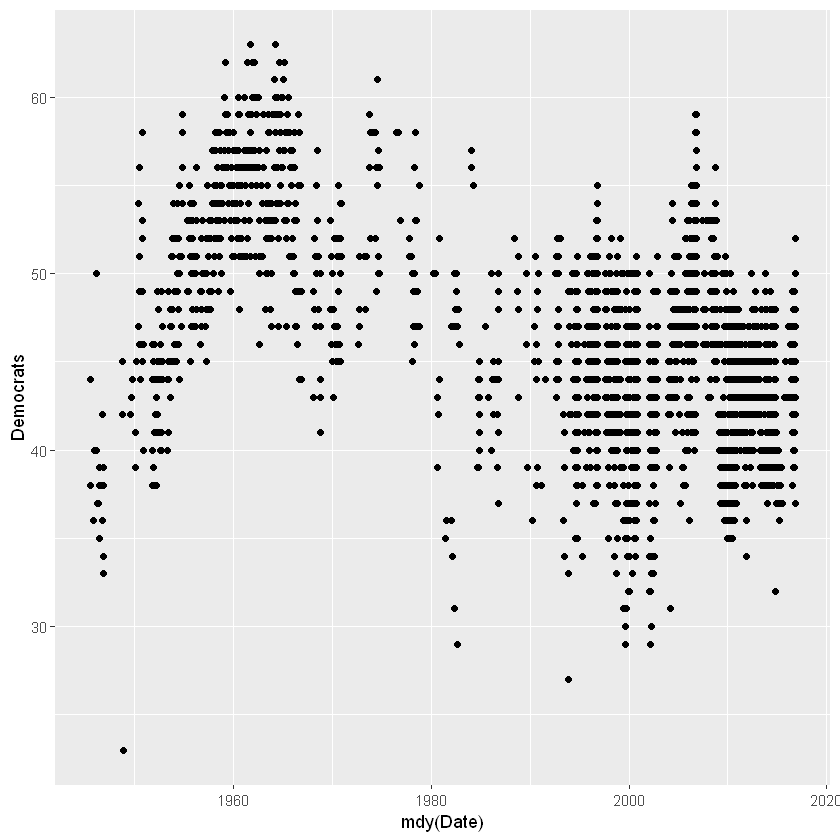

In [6]:
library(lubridate)
library(tidyverse)
library(ggplot2)

generic_ballot <- read.csv("https://assets.datacamp.com/production/repositories/1934/datasets/b67f87da8083695e8d49387a37d0ff30f341bded/generic_ballot.csv",
                          header = TRUE, sep = ",")
generic_ballot %>% 
    head(10)

ggplot(generic_ballot, aes(x = mdy(Date), y = Democrats)) +
    geom_point()

## Time Series Analysis for the generic ballot
### Averaging by year

`summarise()` ungrouping output (override with `.groups` argument)



ElecYear,Democratic.Margin
<int>,<dbl>
1946,0.5238095
1948,-0.3333333
1950,11.1250000
1952,-0.9750000
1954,9.3953488
1956,11.0606061


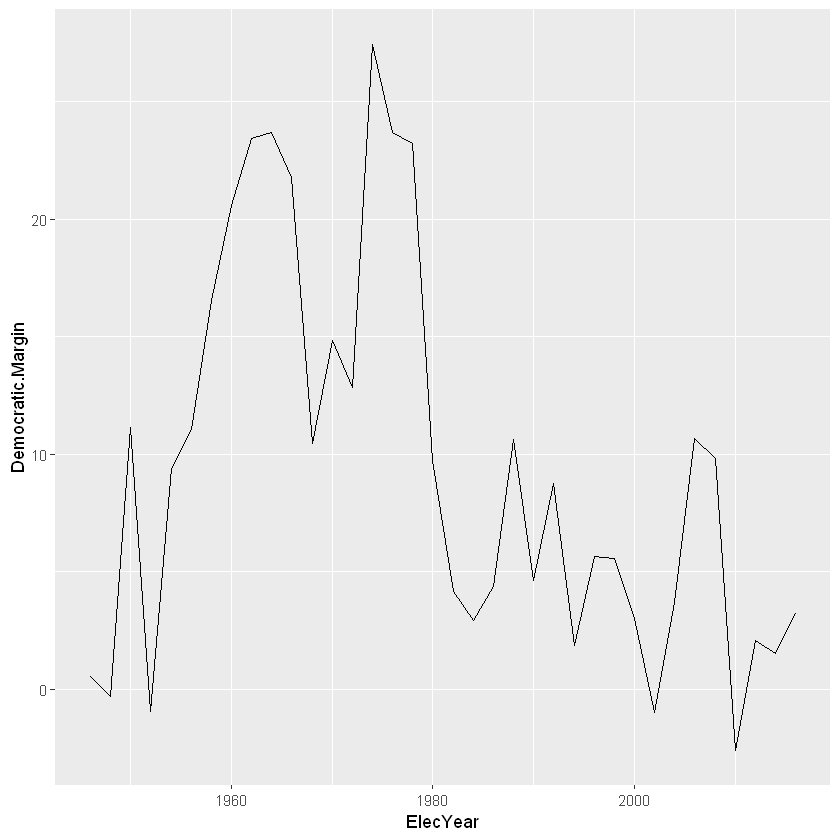

In [11]:
democratic_lead <- generic_ballot %>% 
    mutate(Democratic.Margin = Democrats - Republicans)
over_time <- democratic_lead %>% 
    group_by(ElecYear)  %>% 
    summarize(Democratic.Margin = mean(Democratic.Margin))
head(over_time)

ggplot(over_time, aes(ElecYear, Democratic.Margin)) +
    geom_line()

### Averaging by month
Steps:
    
1. Group polls by month and year in which they were taken:
        
        data  %>% group_by(year, month)   
2. Create an average reading of the Democratic margin in that month
        
        data  %>% group_by(year, month)  %>% 
           summarize(support =  mean(support))       
3. Analyze and visualize with ggplot:
- Make ggplot object:
        
        ggplot(data, aes(x=month, y=support)) +
- Add geometric layer:
        
        geom_point() +
           geom_smooth(span = 0.2)

`summarise()` regrouping output by 'yr' (override with `.groups` argument)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



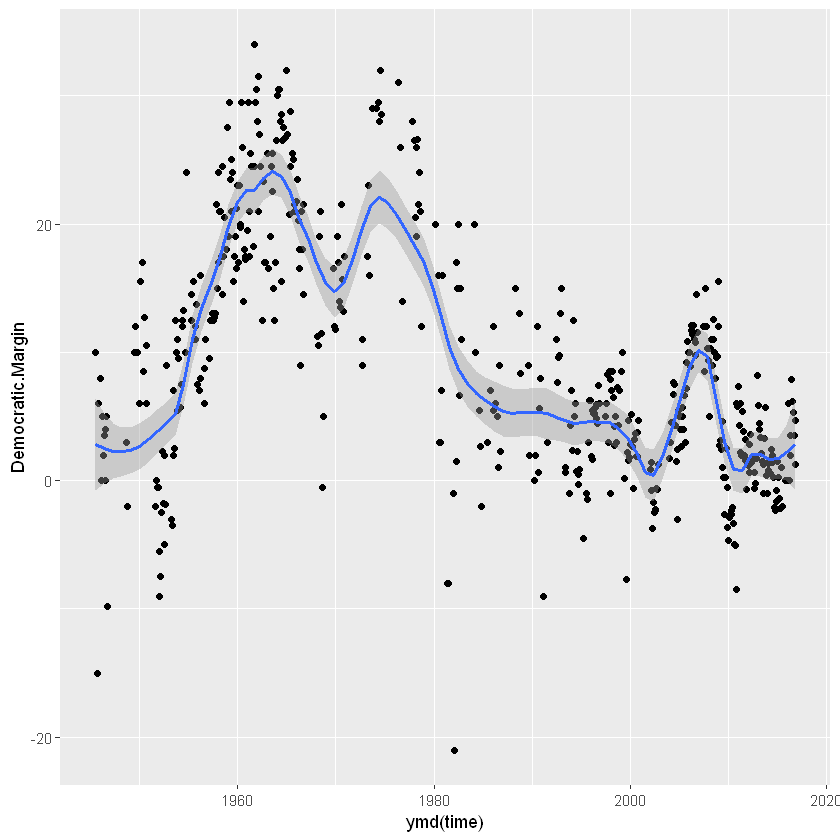

In [13]:
timeseries <- democratic_lead %>% 
    mutate(Date = mdy(Date),
          month = month(Date),
          yr = year(Date))

timeseries <- timeseries %>% 
    group_by(yr, month) %>% 
    summarize(Democratic.Margin = mean(Democratic.Margin))

timeseries_plot <- timeseries %>%
  mutate(time = sprintf("%s-%s-%s",yr,month,"01"))

ggplot(timeseries_plot,aes(x=ymd(time),y=Democratic.Margin)) +
  geom_point() +
  geom_smooth(span = 0.2)

## Calculating and Visualizing Error in Polls

In [14]:
# Mutating two variables for the Democrats' margin in polls and election day votes
poll_error <- generic_ballot %>%
  mutate(Dem.Poll.Margin = Democrats - Republicans,
         Dem.Vote.Margin = DemVote - RepVote)

# Averaging those two variables per year and mutate the "error" variable
poll_error <- poll_error %>%
  group_by(ElecYear) %>%
  summarise(Dem.Poll.Margin = mean(Dem.Poll.Margin),
            Dem.Vote.Margin = mean(Dem.Vote.Margin)) %>%
  mutate(error = Dem.Poll.Margin - Dem.Vote.Margin)

`summarise()` ungrouping output (override with `.groups` argument)



In [15]:
# Calculating the root-mean-square error of the error variable
rmse <- sqrt(mean(poll_error$error^2))

# Multiplying the RMSE by 1.96 to get the 95% confidence interval, or "margin of error"
CI <- rmse * 1.96

# Adding variables to the dataset for the upper and lower bound of the `Dem.Poll.Margin` variable
by_year <- poll_error %>%
  mutate(upper = Dem.Poll.Margin + CI,
         lower = Dem.Poll.Margin - CI)

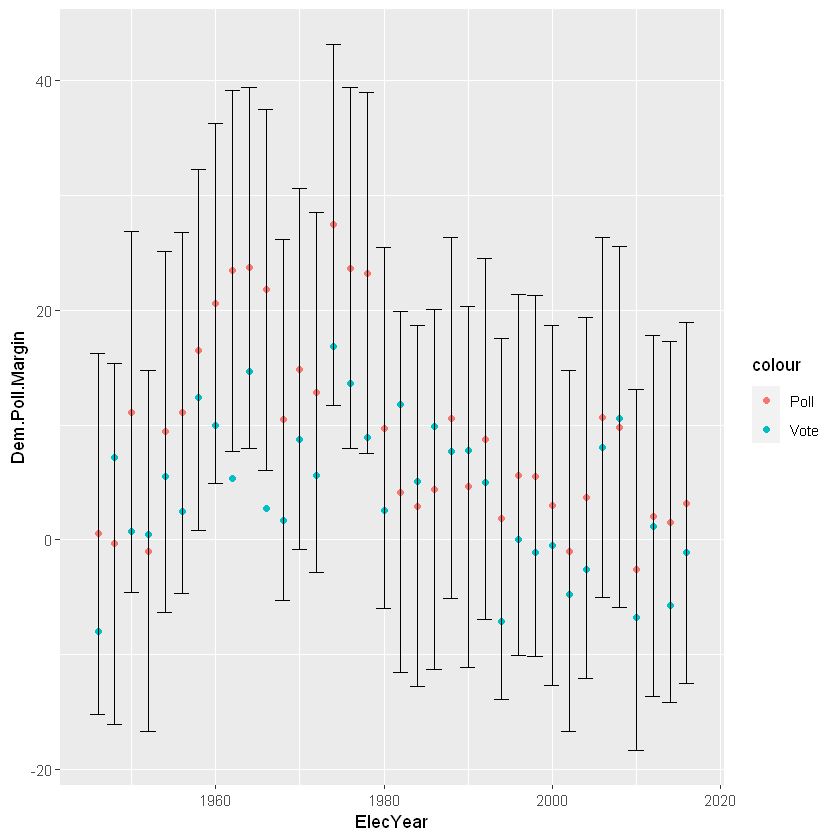

In [16]:
# Plot
ggplot(by_year) + 
    geom_point(aes(x=ElecYear, y=Dem.Poll.Margin, col="Poll")) +
    geom_point(aes(x=ElecYear, y=Dem.Vote.Margin, col="Vote")) +
    geom_errorbar(aes(x=ElecYear, ymin=lower, ymax=upper))

## Predicting congressional elections with linear regression

In [20]:
# Fitting a model predicting Democratic vote margin with Democratic poll margin
model <- lm(Dem.Vote.Margin ~ Dem.Poll.Margin, data=by_year)
summary(model)


Call:
lm(formula = Dem.Vote.Margin ~ Dem.Poll.Margin, data = by_year)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.9701 -3.2791 -0.1947  3.0657 10.4314 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -0.80939    1.19857  -0.675    0.504    
Dem.Poll.Margin  0.52693    0.09582   5.499 3.86e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.758 on 34 degrees of freedom
Multiple R-squared:  0.4708,	Adjusted R-squared:  0.4552 
F-statistic: 30.24 on 1 and 34 DF,  p-value: 3.855e-06


In [21]:
# New dataframe that has the prediction variable and value
predictdata <- data.frame("Dem.Poll.Margin" = 5)
predict(model, predictdata)

1 
1.825248

- Democratic Polling margin translates into an actual margin of ~1.8%